In [1]:
import quandl
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
quandl.ApiConfig.api_key = 'iB1vwTHbXzBdG755yy2W'

In [3]:
## returns direction of a time sorted df from earliest time -> more recent time, start date and end date.
def get_df_date_info(series):
    d1 = series.iloc[0].name
    d2 = series.iloc[-1].name
    if d1 < d2:
        #low -> high
        return [1, d1, d2]
    if d2 < d1:
        #high -> low
        return [-1, d2, d1]
    
def get_df_date_frequency(series):
    # daily, weekly, fortnightly, monthly, quarterly, annual
    ms = series.index
    difference = ms.to_series() - ms.to_series().shift()
    difference_mean = difference.mean()
    days = difference_mean.days
    hours = difference_mean.seconds/3600
    if hours >= 12.0:
        days += 1
    return days
    

class Macro_Series:
    def __init__(self,name,dataframe):
        self.name = name
        self.df = dataframe
        
        time_data = get_df_date_info(dataframe)
        self.direction = time_data[0]
        self.start_date = time_data[1]
        self.end_date = time_data[2]
        self.freq = get_df_date_frequency(dataframe)
        ##print(self.name, self.start_date.year, self.start_date.month)

In [4]:
class Stock_Macro:
    def __init__(self,stock_code,dateframe):
        self.stock_code = stock_code
        self.df = dataframe

        time_data = get_df_date_info(dataframe)
        self.direction = time_data[0]
        self.start_date = time_data[1]
        self.end_date = time_data[2]

In [5]:
def calculate_pct_change(df):
    return df.join(df.pct_change().iloc[:,0].rename('pct_change'))

def normalise(df):
    norm = df.iloc[:,0] / np.absolute(df.iloc[:,0].max())
    return df.join(norm.rename('norm'))

In [6]:
def get_macro_data():
    macro_data = {}
    macro_data['us_tr_bill_3m'] = Macro_Series('us_tr_bill_3m',
                                               calculate_pct_change(normalise(quandl.get('FRED/TB3MS',column_index='1'))) )
    macro_data['us_gdp_potential'] = Macro_Series('us_gdp_potential',
                                                  calculate_pct_change(normalise(quandl.get('FRED/GDPPOT', column_index='1'))) )
    macro_data['us_nat_unemployment'] = Macro_Series('us_nat_unemployment',
                                                     calculate_pct_change(normalise(quandl.get('FRED/NROUST',column_index='1'))) )

    pred_gov_net_lending_keys = {'FRED/GGNLBPDEA188N':'Germany','FRED/GGNLBPFRA188N':'France','FRED/GGNLBPJPA188N':'Japan','FRED/GGNLBPCAA188N':'Canada',
                                 'FRED/GGNLBPCNA188N':'China','FRED/GGNLBPRUA188N':'Russia','FRED/GGNLBAGBA188N':'UK','FRED/GGNLBPEZA188N':'EU',
                                 'FRED/GGNLBPUSA188N':'US','FRED/GGNLBAINA188N':'India'}

    pred_gov_net_lending = []
    for i in pred_gov_net_lending_keys:
        name = pred_gov_net_lending_keys[i] + '_pred_gov_net_lending'
        pred_gov_net_lending.append( Macro_Series(name,
                                                  calculate_pct_change(normalise(quandl.get(i,column_index='1'))) ))
    macro_data['pred_gov_net_lending'] = pred_gov_net_lending
    
    macro_data['fed_total_public_debt'] = Macro_Series('fed_total_public_debt', 
                                                       calculate_pct_change(normalise(quandl.get('FRED/GFDEBTN',column_index='1'))) )

    gov_gross_debt_keys = {'FRED/GGGDTADEA188N':'Germany','FRED/GGGDTAFRA188N':'France','FRED/GGGDTAJPA188N':'Japan','FRED/GGGDTACAA188N':'Canada',
                           'FRED/GGGDTACNA188N':'China','FRED/GGGDTARUA188N':'Russia','FRED/GGGDTAGBA188N':'UK','FRED/GGGDTAEZA188N':'EU',
                           'FRED/GGGDTAUSA188N':'US','FRED/GGGDTAINA188N':'India',}
    gov_gross_debt = []
    for i in gov_gross_debt_keys:
        name = gov_gross_debt_keys[i] + '_gov_gross_debt'
        gov_gross_debt.append( Macro_Series(name,
                                            calculate_pct_change(normalise(quandl.get(i,column_index='1'))) ))
    macro_data['gov_gross_debt'] = gov_gross_debt
    
    macro_data['crude_oil_historical'] = Macro_Series('crude_oil_historical', 
                                                      calculate_pct_change(normalise(quandl.get('BP/CRUDE_OIL_PRICES',column_index='1'))) )
    
    macro_data['crude_oil_opec'] = Macro_Series('crude_oil_opec',
                                                calculate_pct_change(normalise(quandl.get('OPEC/ORB',column_index='1'))) )
    
    macro_data['gold_price'] = Macro_Series('gold_price',
                                            calculate_pct_change(normalise(quandl.get('LBMA/GOLD',column_index='1'))) )
    return macro_data

In [7]:
mc_data = get_macro_data()
tst = mc_data['gold_price'].df

In [8]:
def skewed_normal(mu, sigma, minimum, maximum):
    while True:
        s = np.rint(np.random.normal(mu, sigma)).astype(int)
        if (minimum < s & s < maximum ):
            break  
    return s

def split_df(df, mu=20, sigma=30, minimum=5, maximum=150):
    ub = math.floor(len(df)/2)    
    if (maximum > ub):
        maximum = ub
    interval_start,interval_number,intervals = 0,1,df.iloc[:,0].astype(int).as_matrix()
    intervals[:] = 0
    while True:
        s = skewed_normal(mu,sigma,minimum,maximum)
        intervals[interval_start:interval_start+s] = interval_number
        interval_number += 1
        interval_start += s
        if interval_start > len(df) - 1:
            break
    
    intervals_pd = pd.Series(intervals,index=df.index).rename('Intervals')
    df = df.join(intervals_pd)
    return df

In [9]:
def analyse_macro_data(macro_data,stock_data,display=False):
    print("Length:",len(macro_data))
    count = 0
    for i in macro_data:
        count += 1
        print('-------------')
        print(i)
        print(type(macro_data[i]))
        macro_type_error = str('Value inputted:\n\n' + str(macro_data[i]) + '\n\nIs not of type list or class Macro_Series. It is of type ' + str(type(macro_data[i])))
        if type(macro_data[i]) is Macro_Series:
            ## Macro Series analysis - global factor
            print('Macro_Series analysis')
            if display:
                plt.figure(count)
                plt.title(i)
                plt.plot(macro_data[i].df.iloc[:,1:])
            
        elif type(macro_data[i]) is list:
            for j in macro_data[i]:
                count += 1
                print(j.name)
                if type(j) is Macro_Series:
                    ## Macro Series analysis - per country
                    print('Macro_Series analysis - per country')
                    if display:
                        plt.figure(count)
                        plt.title(j.name)
                        plt.plot(j.df.iloc[:,1:])
                    
                else:
                    raise ValueError(macro_type_error)
        else:
            raise ValueError(macro_type_error)
    return

In [10]:
def read_format_stock(path):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df['1. open'] = df['1. open'].astype(float)
    df['2. high'] = df['2. high'].astype(float)
    df['3. low'] = df['3. low'].astype(float)
    df['4. close'] = df['4. close'].astype(float)
    df['5. volume'] = df['5. volume'].astype(float)
    return df

In [11]:
googl_path = os.path.join(os.getcwd(),"..","..","Data","GOOGL2.csv")
googl_df = read_format_stock(googl_path)
googl_df.head()

,date,1. open,2. high,3. low,4. close,5. volume
0,2004-08-19,100.01,104.06,95.96,100.335,44659000.0
1,2004-08-20,101.01,109.08,100.50,108.310,22834300.0
2,2004-08-23,110.76,113.48,109.05,109.400,18256100.0
3,2004-08-24,111.24,111.60,103.57,104.870,15247300.0
4,2004-08-25,104.76,108.00,103.88,106.000,9188600.0


In [12]:
analyse_macro_data(mc_data,googl_df)

Length: 9
-------------
us_tr_bill_3m
<class '__main__.Macro_Series'>
Macro_Series analysis
-------------
us_gdp_potential
<class '__main__.Macro_Series'>
Macro_Series analysis
-------------
us_nat_unemployment
<class '__main__.Macro_Series'>
Macro_Series analysis
-------------
pred_gov_net_lending
<class 'list'>
Germany_pred_gov_net_lending
Macro_Series analysis - per country
France_pred_gov_net_lending
Macro_Series analysis - per country
Japan_pred_gov_net_lending
Macro_Series analysis - per country
Canada_pred_gov_net_lending
Macro_Series analysis - per country
China_pred_gov_net_lending
Macro_Series analysis - per country
Russia_pred_gov_net_lending
Macro_Series analysis - per country
UK_pred_gov_net_lending
Macro_Series analysis - per country
EU_pred_gov_net_lending
Macro_Series analysis - per country
US_pred_gov_net_lending
Macro_Series analysis - per country
India_pred_gov_net_lending
Macro_Series analysis - per country
-------------
fed_total_public_debt
<class '__main__.Macro_

In [13]:
df_out = split_df(tst)
df_out.head()

,USD (AM),norm,pct_change,Intervals
Date,,,,
1968-01-02,35.18,0.018550,NaN,1
1968-01-03,35.16,0.018539,-0.000569,1
1968-01-04,35.14,0.018529,-0.000569,1
1968-01-05,35.14,0.018529,0.000000,1
1968-01-08,35.14,0.018529,0.000000,1


In [57]:
def compare_pct_change(ms_1, ms_2):
    
    start_date = max(ms_1.start_date, ms_2.start_date)
    ms_1_freq = ms_1.freq
    ms_2_freq = ms_2.freq
    
    ms_1_diff = ms_1.df.index.difference(ms_2.df.index)
    ms_2_diff = ms_2.df.index.difference(ms_1.df.index)

    df_1 = pd.DataFrame(ms_1.df.iloc[:,1].rename('ms_1_norm'))
    df_2 = pd.DataFrame(ms_2.df.iloc[:,1].rename('ms_2_norm'))
    
    merged = df_1.join(df_2)
    merged = merged[(merged.index > start_date)]
    merged = merged.fillna(method='ffill')
    print(merged)
    plt.plot(merged)
    
       

            ms_1_norm  ms_2_norm
Date                            
2003-01-03   0.181387   0.219072
2003-01-06   0.187767   0.218219
2003-01-07   0.183865   0.211185
2003-01-08   0.182837   0.205074
2003-01-09   0.186976   0.209692
2003-01-10   0.186211   0.211895
2003-01-13   0.185790   0.211895
2003-01-14   0.186528   0.214666
2003-01-15   0.185552   0.217864
2003-01-16   0.184999   0.219356
2003-01-17   0.188874   0.220422
2003-01-20   0.187609   0.221772
2003-01-21   0.187477   0.219569
2003-01-22   0.189428   0.219498
2003-01-23   0.191563   0.214453
2003-01-24   0.191985   0.217153
2003-01-27   0.195518   0.214311
2003-01-28   0.193224   0.211966
2003-01-29   0.195017   0.215306
2003-01-30   0.191405   0.217296
2003-01-31   0.195281   0.218219
2003-02-03   0.194569   0.215235
2003-02-04   0.197654   0.213032
2003-02-05   0.203006   0.216869
2003-02-06   0.196414   0.218646
2003-02-07   0.195386   0.222056
2003-02-10   0.196019   0.222980
2003-02-11   0.190957   0.222767
2003-02-12

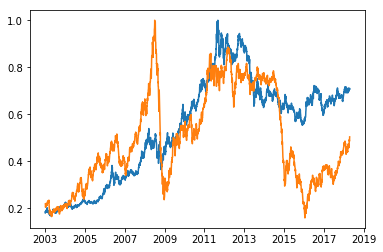

In [58]:
df1 = mc_data['gold_price']
df2 = mc_data['crude_oil_opec']

compare_pct_change(df1,df2)

            ms_1_norm  ms_2_norm
Date                            
1934-02-01   0.038037        NaN
1934-03-01   0.014724        NaN
1934-04-01   0.009202        NaN
1934-05-01   0.009816        NaN
1934-06-01   0.009202        NaN
1934-07-01   0.009202        NaN
1934-08-01   0.011656        NaN
1934-09-01   0.012883        NaN
1934-10-01   0.016564        NaN
1934-11-01   0.015337        NaN
1934-12-01   0.014110        NaN
1935-01-01   0.012270        NaN
1935-02-01   0.011656        NaN
1935-03-01   0.009202        NaN
1935-04-01   0.009202        NaN
1935-05-01   0.009202        NaN
1935-06-01   0.009202        NaN
1935-07-01   0.009202        NaN
1935-08-01   0.009816        NaN
1935-09-01   0.012270        NaN
1935-10-01   0.012270        NaN
1935-11-01   0.009816        NaN
1935-12-01   0.009202        NaN
1936-01-01   0.012270        NaN
1936-02-01   0.012270        NaN
1936-03-01   0.012270        NaN
1936-04-01   0.012270        NaN
1936-05-01   0.012270        NaN
1936-06-01

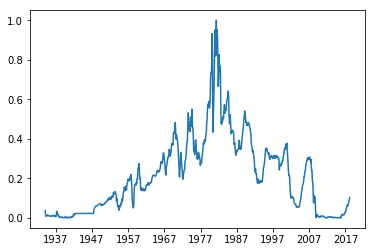

In [59]:
df1 = mc_data['us_tr_bill_3m']
df2 = mc_data['crude_oil_historical']

compare_pct_change(df1,df2)